# Finding Lane Lines on the Road
#### *Udacity Self-Driving Car Engineer Nanodegree*

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Package usage
All new code is contained in the separate module `laneLines.py`.

In [2]:
import laneLines

The primary object from `laneLines` is the `Pipeline` class, which performs the necesary transformations and encapsulates parameters that might be modified for different conditions.

In [3]:
pipeline = laneLines.Pipeline()

First, I'll test the output on the collection of supplied static test images. I defined a separate `pretty_show` method for this that returns a Matplotlib figure/axis pair rather than just using OpenCV functions to draw directly on the image. This allows us to visualize the results of several steps in the pipeline at once.

This view shows the lines which are finally returned as thick orange bars,
the filtered Hough transform candidates as small magenta line segments,
and the trapezoidal search region as a pale orange-transparent overlay with a black dashed outline.

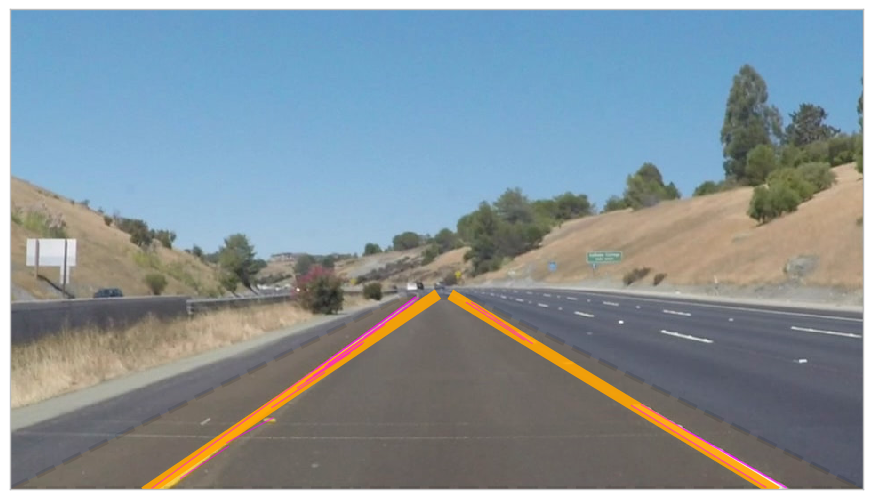

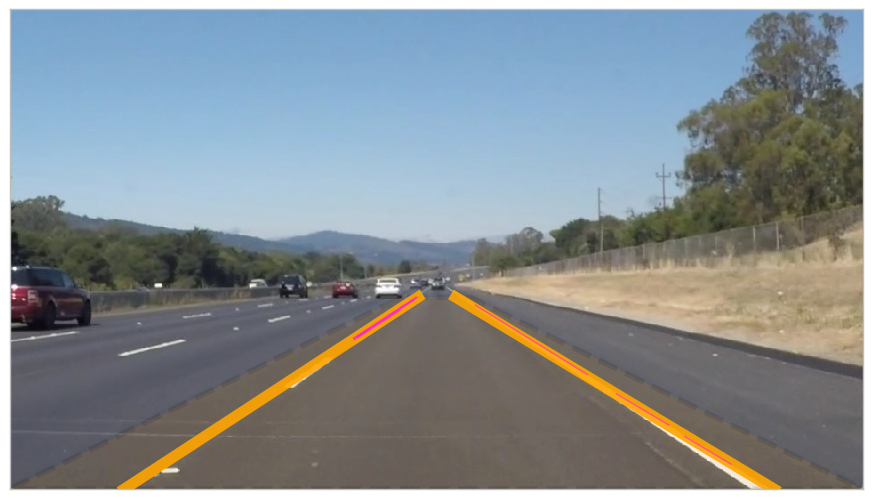

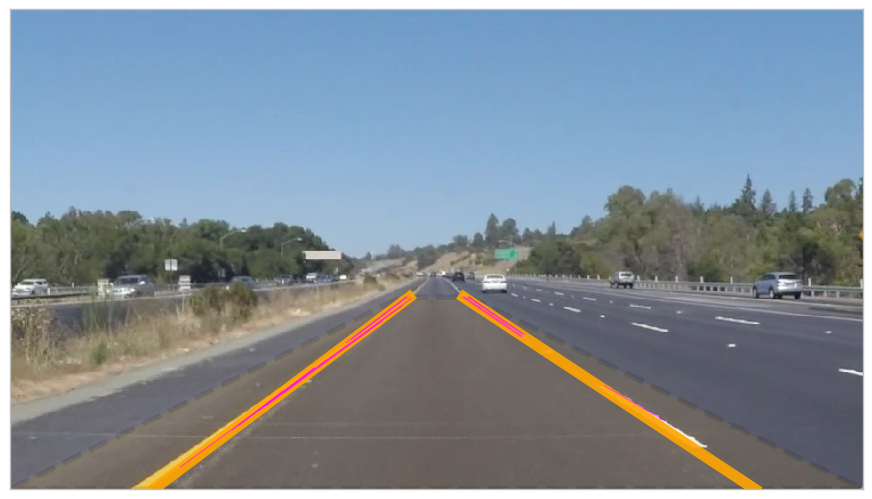

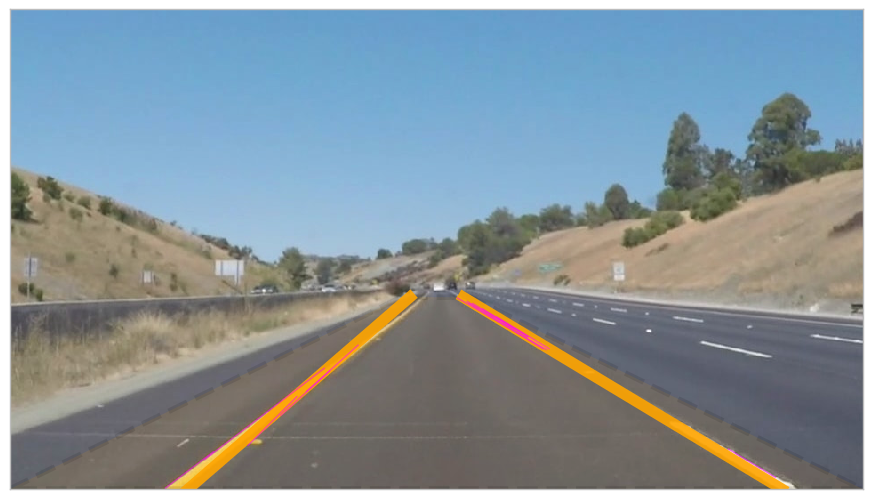

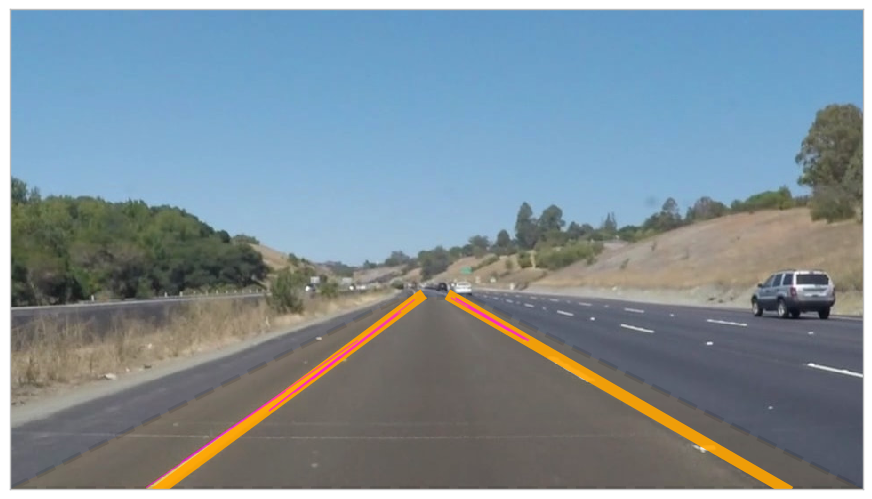

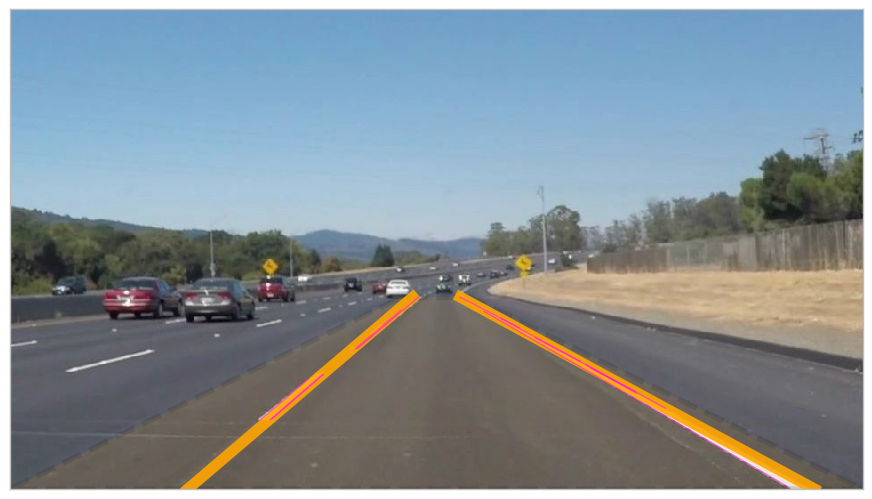

In [4]:
import os
for fname in os.listdir("test_images/"):
    img = mpimg.imread('test_images/%s' % fname)
    fig, ax = pipeline.pretty_show(img)
    fig.savefig(
        ('test_images_output/%s' % fname)
        .replace('.jpg', '-pretty.jpg'),
        # Crop out borders around axis for saving:
        bbox_inches=ax
        .get_window_extent()
        .transformed(fig.dpi_scale_trans.inverted())
    )

The instantiated `Pipeline` object also has a `__call__` method which converts color image ndarrays to image ndarrays (of shape `(nrows, ncols, 3)`).

In [5]:
converted = pipeline(img)
img.shape, converted.shape

((540, 960, 3), (540, 960, 3))

For the most part, this allows the object to be used as the pipeline function requested, though it was not clear whether this pipeline should save images to a file as a side effect. Since doing so would significantly degrade performance when converting videos, I compromised by making a tiny wrapper function to meet this possible requirement by keyword argument.

In [6]:
def process_image(image, savepath=None):
    converted = pipeline(image)
    if savepath is not None:
        laneLines.save_image(converted, savepath)
    return converted

This function can then be applied to all the test images.

In [7]:
for fname in os.listdir("test_images/"):
    img = mpimg.imread('test_images/%s' % fname)
    savepath = 'test_images_output/%s' % fname
    ip = process_image(img, savepath)

I also wrote a separate `debug` mode, enterable by an attribute. Probably the `pretty_show` method should just be merged into this. However, it is useful to be able to return either image ndarrays or matplotlib figure/axis pairs, for different uses. The first is better for actual pipeline use (e.g., for converting videos), and the second woudld be better for debug purposes.

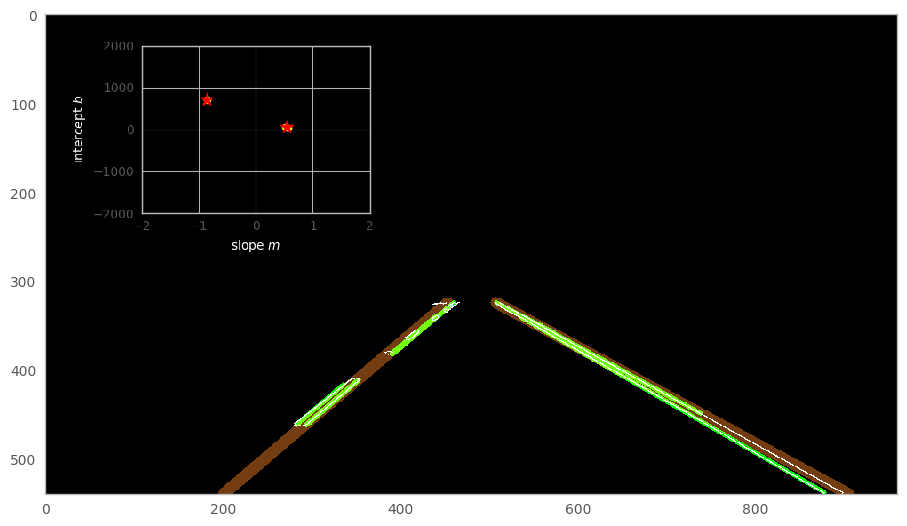

In [8]:
pipeline.debug = True
plt.imshow(pipeline(img))
plt.grid(False)

Here, the background image is no longer the orignal image, but instead the output after Canny edge detection. Overlaid on this are, again, the  filtered Hough candidates and the two finally chosen lines (in new colors). Inset at the top left is a scatterplot of all the filtered Hough candidates in `(slope, intercept)` space (small yellow points), as well as the two chosen cluster means.

For more ambiguous situations (such as `challenge.mp4` in which we're rounding a corner while a tree's shadow is dappled across the mixed cement/asphalt road surface), the yellow points spread out considerably, and it is less obvious in this view where the cluster means should be.

### Parameters
The `Pipeline` class accepts a number of keyword arguments at instantiation, which are described in the constuctor docstring.

In [9]:
help(pipeline.__init__)

Help on method __init__ in module laneLines:

__init__(horizon=0.6, horizonRadius=None, hoodClearance=0, gaussianRadius=5, lowCannyThreshold=50, highCannyThreshold=150, rho=20, theta=0.02617993877991494, houghThreshold=64, minLineLen=50, maxLineGap=20, minAbsSlope=0.5, maxAbsSlope=2) method of laneLines.Pipeline instance
    Parameters
    ----------
    horizon : float, optional
        How far down on the image the top edge of the search region trapezoid
        should be. Specified as a number in (0.0, 1.0),
        where 0.0 is at the top of the image and 1.0, the bottom.
    hozironRadius : float, optional
        Half-width of the top edge of the search region trapezoid. in units of (sub)pixels.
    gaussianRadius : int, optional
        Diameter of Gaussian pre-smoothing.
    lowCannyThreshold : int, optional
    highCannyThreshold : int, optional
        Hysteresis thresholds for Canny edge detection.
    rho : float, optional
        Radius increment for assembling the Hough a

I could have documented other methods, but I didn't.

## Pipeline steps
Below, I'll show individual methods used in the `__call__(self, image, lineHistory=None)`.
Broadly, the `__call__` method comprises calling 
1. `prepare`,
2. `find_lines`,
3. `deduplicate_lines`,
4. `smooth_history`,
5. `recut_lines`, and
6. `bake_lines`.

First, I do a small Gaussian blur and Canny edge detection. Rather than first converting the image to greyscale and then doing the preprocessing on the reduced data, I did the blurring and edge detection on each channel separately, then took the pixelwise maximum of the three.
After these steps, I restricted the edge-detected image to a trapezoidal region-of-interest, setting values outside this region to 0.

In [10]:
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter, LatexFormatter
from IPython.core.display import HTML

class src(object):
    
    def __init__(self, obj):
        self.obj = obj
        
    def _repr_latex_(self):
        return self.repr(LatexFormatter)
        
    def _repr_html_(self):
        return self.repr(HtmlFormatter, noclasses=True)

    def repr(self, Formatter, **kwargs):
        return highlight(
            inspect.getsource(self.obj),
            PythonLexer(),
            Formatter(**kwargs)
        )

In [11]:
src(pipeline.prepare)

Next, I passed the image with highlighted edge pixels to OpenCV's probabilistic Hough transform function, `cv2.HoughLinesP`. This function returns a list of four-element vectors of the form `[x1, y1, x2, y2]` denoting the endpoints of line segments.
To facilitate operations on line segments, I wrote a small `LineSegment` class, which internally stores segments in such a four-vector format, but provides other convenience methods and attributes, to be used later.

In [12]:
src(pipeline.find_lines)

Since I liberally took the per-pixel maximum of the detected edges per color, and since my default parameters for the Hough transform were also not very restrictive, I got lots of detected line segments. This was intentional, since I planned to filter them down again by known (that is, assumed) characteristics of the lane lines, and then divide them into exactly two clusters for the left and right lines.

The important step is the call to `sklearn.cluster.KMeans`, by which I explicitly seek out exactly two lines. I experimented briefly with `sklearn.cluster.AffinityPropagation` as well, but found the results to be no better.

Finally, I placed the line with the larger slope first in the returned list, for consistency from frame-to-frame when doing sliding-window averaging while processing videos (see below).

In [13]:
src(pipeline.deduplicate_lines)

Pre $k$-means filtering was done by the simple boolean method `check_line`, which just set reasonable limits on the line slope.

In [14]:
src(pipeline.check_line)

At this point, if I were running on a video rather than individual frames, I may have passed in `smoothing=True`. In this case, the pipeline object is actually stateful, and `smooth_history` is called.

Here, new pairs of `LineSegment` objects are accumulated, and the running average of the last few slope/intercept pairs is used to construct a new line pair for this frame. For convience, the old segments are accumlated in a `collections.deque`, simply because this structure will automatically delete old pairs as new ones are added once the assigned holding capacity is reached.

In [15]:
src(pipeline.smooth_history)

Whether smoothed or not, the line (segment) pairs are stored in the form of their endpoints. I next slide these endpoints up or down as necessary to reach the top and bottom edges of the region of interest.

In [16]:
src(pipeline.recut_lines)

The lines are then drawn on top of the output image using the earlier-defined functions `weighted_img` and `draw_hough_lines`. If `self.debug == True`, this method is also used to draw the debug lines, and the inset plot is drawn with matplotlib, converted to OpenCV-style array/image, and drawn on top of the output with `weighted_img` as well.

## Future work
While I could have achieved better results on some portions of the challenge video by tuning the Canny and Hough parameters a little more, I found it more interesting to find an elegant way to deduplicate the Hough candidates (and, evidently, to overengineer lots of other things).

Each of the videos (and the challenge video in particular) benefited from hand-tuning some of the many parameters to the pipeline constructor. If some measure of quality of the results could be obtained (say, comparison to human-labeled ground truth), then this suggests a supervised learning approach could be used to adjust the parameters based on features of the image. Of course, if the supervised learning approach is a convolutional neural network, then it might (or might not!) be better simply to output the parameters for the two lane lines directly. Smoothness over time could even be achieved by using some LSTM layers.

Another possible optimization might be to use a different parameterization of the line segments for the clustering--two lines which are in fact very similar might have very different slope-intercept parameterizations, and in fact, loosely speaking,
the Jacobian 
$$\left[
\begin{array}{cc}
\frac{\partial \Delta m }{ \partial m}
&
\frac{\partial \Delta m }{ \partial b}
\\
\frac{\partial \Delta b }{ \partial m }
&
\frac{\partial \Delta b }{ \partial b }
\end{array}
\right]
$$
of the difference $\left[\Delta m, \Delta b\right]$,
for two lines both "near" $(m, b)$ in some origin-agnostic sense
appears intuitively to depend on the values of $m$ and $b$, since, e.g., small perturbations in slope can cause large perturbations in intercept, when the rotation is about a point far from the intercept.
Since $k$-means relies on meaningful distances between points to do its work this distortion might be problematic.

It's not clear to me that using, say, a radius-angle parameterization would necessarily alleviate this problem (if indeed it is a problem),
but, for the same reason that the $r,\theta$ parameterization is used internally by the OpenCV Hough transform implementation (avoidance of singularities), it might be useful here. Of course, since I explicitly filtered out lines with too high or too low absolute slopes, the specific problem of zero- or infinite-slope lines wasn't a real issue.

Separately, it might be useful to fit objects such other than lines to the images. Arcs naturally come to mind--in fact, arc segments would be a natural generalization of line segments. Since the Hough transform can work on any simply-parameterized geometric objects, this seems like it would be a straightforward upgrade.

It would also certainly be useful to expose the actual fitted objects in some sort of API for, e.g., control purposes. Knowing the equations for the lines found would be much more useful than simply having an image array with them highlighted (which is basically no improvement on the original image as far as computational usefulness goes).

Finally, the moving-window smoothing can certainly done in a much more clever way. Smoothing (properly called "filtering") is a whole region of mathematical research, which should be addressed in later terms of the Udacity SDC program. For instance, it might be useful to use a Kalman filter to track the parameters of the line segments instead of just tracking their means with this fixed-duration moving window. I've definitely seen freeze-frame visualizations (from Waymo?) in which such an approach was evident (histograms were plotted above the lane lines in 3D space, in a plane perpindicular to the car's grille.

## Test on Videos

Though you can't watch them in the generated PDF, I'll here make the videos and put them in the `test_videos_output` folder.

In [17]:
pl = laneLines.Pipeline(horizon=.6, minLineLen=42)
pl.process_video(
    'test_videos/solidWhiteRight.mp4', 
    'test_videos_output/solidWhiteRight.mp4'
)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 53.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



In [18]:
pl = laneLines.Pipeline(
    minLineLen=42, horizon=.6, 
    theta=np.pi/180, houghThreshold=64
)
pl.process_video(
    'test_videos/solidYellowLeft.mp4',
    'test_videos_output/solidYellowLeft.mp4', 
)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:13<00:00, 51.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



The pipeline fails on the challenge video when the road surface switches from asphalt to concrete brifely, and a mass of tree shadows on the left causes suprious line detection. Some parameter tuning (and perhaps extra preprocessing for the road surface change) might help here in future work. The separate Gaussian+Canny preprocessing on the three input color channels was specifically added to deal with this transition, and did help somewhat.

In [19]:
pl = laneLines.Pipeline(
    horizon=.62, hoodClearance=.1, horizonRadius=.04,
    minLineLen=32, houghThreshold=42,
)
pl.process_video(
    'test_videos/challenge.mp4',
    'test_videos_output/challenge.mp4',
)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 33.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



I'll also do the challenge video with `debug` set to `True`, since that's the video where it's most informative.

In [20]:
pl.debug = True
pl.process_video(
    'test_videos/challenge.mp4',
    'test_videos_output/challenge_debug.mp4',
)

[MoviePy] >>>> Building video test_videos_output/challenge_debug.mp4
[MoviePy] Writing video test_videos_output/challenge_debug.mp4


100%|██████████| 251/251 [00:32<00:00,  8.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_debug.mp4 

